# 1. Describe the data
- It has 50 rows, which are 50 states
- There are 8 variables:
    - Population: population of the state in thousands (e.g., 3615 represents 3,615,000 people)  (Thousands of people)
    - Income: per capita income of the state, likely in US dollars per year (US dollars per year)
    - Illiteracy: percentage of people who are illiterate (unable to read and write) in the state's population (%).
    - LifeExp: average life expectancy in the state, representing the average number of years a person is expected to live (Years)
    - Murder: murder rate per 100,000 inhabitants in the state (Rate per 100,000 people)
    - HSGrad: percentage of people who graduated from high school in the state (%)
    - Frost: average number of days per year when the temperature in the state is below freezing (Days)
    - Area: land area of the state in square miles (Square miles)

# 2. Load packages and data

In [1]:
%%capture
pip install faraway

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
import faraway.utils

In [22]:
import faraway.datasets.statedata
statedata = faraway.datasets.statedata.load()
statedata.index = statedata['State']
statedata = statedata.drop('State', axis=1)
statedata.head()

,Population,Income,Illiteracy,LifeExp,Murder,HSGrad,Frost,Area
State,,,,,,,,
AL,3615,3624,2.1,69.05,15.1,41.3,20,50708
AK,365,6315,1.5,69.31,11.3,66.7,152,566432
AZ,2212,4530,1.8,70.55,7.8,58.1,15,113417
AR,2110,3378,1.9,70.66,10.1,39.9,65,51945
CA,21198,5114,1.1,71.71,10.3,62.6,20,156361


# 3. Linear Regression

In [5]:
lmod = smf.ols('LifeExp ~ Population + Income + Illiteracy + \
    Murder + HSGrad + Frost + Area', statedata).fit()
lmod.sumary()

            coefs stderr tvalues pvalues
Intercept  70.943  1.748   40.59  0.0000
Population  0.000  0.000    1.77  0.0832
Income     -0.000  0.000   -0.09  0.9293
Illiteracy  0.034  0.366    0.09  0.9269
Murder     -0.301  0.047   -6.46  0.0000
HSGrad      0.049  0.023    2.10  0.0420
Frost      -0.006  0.003   -1.82  0.0752
Area       -0.000  0.000   -0.04  0.9649

n=50 p=8 Residual SD=0.745 R-squared=0.74


- Some of the coefficients align with what we would reasonably expect regarding how the predictors influence the response. For instance, higher murder rates understandably reduce life expectancy. However, some variables, like income, do not show a significant impact, which is surprising.

## 3.1. Hypothesis Testing-Based Elimination Procedures 
- Backward Elimination is a straightforward method for selecting model variables. It can be done manually without special software, even in complex hierarchies, by identifying which variables to remove.
    - The process begins with all predictors in the model. The predictor with the highest p-value above a critical value (αcrit) is removed, and the model is refitted. This continues, removing the least significant predictors with p-values above αcrit, until only significant predictors remain.
    - The critical value ($α_{crit}$), or “p-to-remove,” doesn’t have to be 5%. For better prediction performance, a cutoff of 15% to 20% might be more effective. However, for optimal prediction, it’s best to use specialized methods.
- In Forward Selection, we start with an empty model. We add predictors one by one, choosing those with the lowest p-values below αcrit. This process continues until no more predictors can be added, building a model with the strongest statistical relationships.
- In Stepwise Regression, we blend backward elimination and forward selection. This allows us to add or remove variables at each stage, adjusting our decisions as needed.
- Drawbacks of testing-based procedures:
    - Adding or removing variables one by one can overlook the best combination for the most accurate model.
    - P-values should be interpreted cautiously, as multiple tests can reduce their reliability. Removing less significant predictors can make the remaining ones seem more important than they are.
    - Variable selection in model building isn’t always aligned with prediction or explanation goals. This can mean it doesn’t solve the specific problem. Dropped variables might still relate to the response but don’t add extra explanatory power beyond what’s included.
    - Stepwise variable selection often results in smaller models than ideal for prediction. For instance, even if a predictor’s significance isn’t strong, it might still be useful to include it for better predictive accuracy.
- Testing-based variable selection should generally be avoided, except in simple cases with few models or in highly structured hierarchical models.

In [6]:
# Identifying the variable having maximal p-value
lmod.pvalues.idxmax(), lmod.pvalues.max()

('Area', 0.9649075022276266)

In [7]:
# Fit the regression without Area
lmod = smf.ols('LifeExp ~ Population + Income + Illiteracy + \
    Murder + HSGrad + Frost', statedata).fit()
# Identifying the variable having maximal p-value
lmod.pvalues.idxmax(), lmod.pvalues.max()

('Illiteracy', 0.9339977631843397)

In [8]:
# Fit the regression without Area, Illiteracy
lmod = smf.ols(
    'LifeExp ~ Population + Income + Murder + HSGrad + Frost', 
    statedata).fit()
# Identifying the variable having maximal p-value
lmod.pvalues.idxmax(), lmod.pvalues.max()

('Income', 0.9153104342085178)

In [9]:
# Fit the regression without Area, Illiteracy, Income
lmod = smf.ols(
    'LifeExp ~ Population + Murder + HSGrad + Frost', 
    statedata).fit()
lmod.pvalues.idxmax(), lmod.pvalues.max()

('Population', 0.0520051350334265)

In [10]:
# Fit the regression without Area, Illiteracy, Income, Population
lmod = smf.ols(
    'LifeExp ~ Murder + HSGrad + Frost', statedata).fit()
lmod.sumary()

           coefs stderr tvalues pvalues
Intercept 71.036  0.983   72.25  0.0000
Murder    -0.283  0.037   -7.71  0.0000
HSGrad     0.050  0.015    3.29  0.0020
Frost     -0.007  0.002   -2.82  0.0070

n=50 p=4 Residual SD=0.743 R-squared=0.71


- The decision to remove the Population variable is a tough one. Including it could make interpretation easier.
- The R² value only drops slightly from 0.74 to 0.71 after removing four predictors, showing a minor impact on the model’s fit.
- It’s important to note that the omitted variables might still be related to the response.

In [11]:
lmod = smf.ols(
    'LifeExp ~ Illiteracy + Murder + Frost', statedata).fit()
lmod.sumary()

            coefs stderr tvalues pvalues
Intercept  74.557  0.584  127.61  0.0000
Illiteracy -0.602  0.299   -2.01  0.0500
Murder     -0.280  0.043   -6.45  0.0000
Frost      -0.009  0.003   -2.94  0.0052

n=50 p=4 Residual SD=0.791 R-squared=0.67


- Illiteracy is associated with life expectancy. While replacing it with the high school graduation rate improves the model fit slightly, it doesn’t mean illiteracy isn’t important.
- This procedure can’t always distinguish between significant and insignificant predictors.

## 3.2. Criterion-Based Procedures
- If we know a model’s purpose, we can measure how well it meets that goal and choose the one that best fits.
- We choose a model g with parameters ( $\theta$ ) that closely matches the true model f. The difference between g and f can be measured using the Kullback-Leibler distance:
$$ I\left(f,g\right)=\int{f\left(x\right)\log{\left(\frac{f\left(x\right)}{g\left(x\middle|\theta\right)}\right)}dx} $$
    - This metric will have a positive value unless g is exactly equal to f, in which case it will be zero.
    - We can’t directly use this metric because we don’t know the true model f.
    - By substituting the maximum likelihood estimate (MLE) of $\theta$ into the metric and rearranging the equation, we can derive a practical form.
$$ \hat{I}\left(f,g\right)=\int{f\left(x\right)\log{f\left(x\right)}dx}-\int{f\left(x\right)\log{g\left(x\middle|\hat{\theta}\right)}dx} $$
    - The first term is a constant that does not depend on the model g.
- Akaike showed that $\mathbb{E}\left(\hat{I}\left(f,g\right)\right)$ can be estimated by $-\log{L\left(\hat{\theta}\right)}+p+constant$
    - Where p is the number of parameters in the model and the constant depends on the unknown true model.
    - Akaike multipled this by two to get an information criterion: $AIC\ =-2\log{L\left(\hat{\theta}\right)}+2p$
    - In linear regression models, the maximum log-likelihood is expressed as $-2\log{L\left(\hat{\theta}\right)}=n\log{\left(\frac{RSS}{n}\right)}+constant$. This constant is consistent for a specific dataset and error distribution, so it can be ignored when comparing regression models on the same data. However, different types of models require additional considerations.
    - We choose the model that minimizes the AIC, which balances fit and simplicity. The first term, based on RSS, measures fit, while the second term, a penalty (2p), prevents overfitting by discouraging too many predictors. This balance makes AIC a valuable tool for model selection.
    - In Statistics and Machine Learning, the bias-variance trade-off is a key concept. When choosing a model, if the model is too simple, it will likely make biased predictions because it can’t capture the true relationship between the input variables and the output. On the other hand, if the model is too complex, it will overfit the data, leading to high variability in its predictions. The AIC (Akaike Information Criterion) is a method used to balance this trade-off.
- Another popular option is the Bayesian Information Criterion (BIC), which modifies the AIC by replacing the 2p term with $p \log n$. BIC penalizes larger models more strictly, so it tends to favor smaller models compared to AIC. Both AIC and BIC are commonly used to select models.
- Both AIC and BIC are widely used to choose between different models. There’s some debate about which one is better, but generally, AIC is thought to be more suitable for prediction purposes.
    - If we believe there is a true model and we want to choose it from a limited set of alternatives, BIC will likely select the true model as the sample size increases.
    - If we don’t believe in a single true model and are open to considering more alternatives as our sample size grows, the model chosen by AIC will generally perform as well as the best available option.
- Another simple option is the adjusted R². This criterion prefers models with a smaller Residual Sum of Squares (RSS) but avoids using too many degrees of freedom. It follows a similar idea to AIC and BIC but doesn’t have as much theoretical support.

In [31]:
import itertools  # For generating combinations of predictor variables
# Step 1: Prepare the data
# Assume 'statedata' is already loaded as shown previously
# Get the list of columns (predictors) from the statedata dataset, excluding the target variable 'LifeExp'
pcols = list(statedata.columns)
pcols.remove('LifeExp')

# Step 2: Initialize an array to store the Residual Sum of Squares (RSS)
# The length of the array is one more than the number of predictors
rss = np.empty(len(pcols) + 1)

# Step 3: Calculate the Total Sum of Squares (TSS)
# The TSS is the RSS for the null model, where we use the mean of 'LifeExp' as the predictor
rss[0] = np.sum((statedata.LifeExp - np.mean(statedata.LifeExp)) ** 2)

# Step 4: Initialize a list to store the selected variables
selvar = ['Null']  # 'Null' represents the model without any predictors

# Step 5: Perform exhaustive search for the best set of predictors at each level
# Loop over the number of predictors (from 1 to the total number of predictors)
for k in range(1, len(pcols) + 1):    
    # Initialize a dictionary to store the RSS for each combination of k predictors
    RSS = {}    
    # Generate all combinations of k predictors using itertools.combinations
    for variables in itertools.combinations(pcols, k):        
        # Select the predictor variables for the current combination
        predictors = statedata.loc[:, list(variables)]        
        # Add an intercept (constant term) to the predictors
        predictors['Intercept'] = 1        
        # Fit an OLS model using the selected predictors
        res = sm.OLS(statedata.LifeExp, predictors).fit()        
        # Store the Residual Sum of Squares (RSS) for the current model
        RSS[variables] = res.ssr    
    # Find the minimum RSS among all combinations of k predictors
    rss[k] = min(RSS.values())    
    # Append the best set of variables (with the smallest RSS) to the selvar list
    selvar.append(min(RSS, key=RSS.get))
rss.round(3)
# Step 6: Output the selected variables at each step
pd.set_option('display.max_colwidth', None) # show full column
pd.DataFrame(selvar)

,0
0,Null
1,"(Murder,)"
2,"(Murder, HSGrad)"
3,"(Murder, HSGrad, Frost)"
4,"(Population, Murder, HSGrad, Frost)"
5,"(Population, Income, Murder, HSGrad, Frost)"
6,"(Population, Income, Illiteracy, Murder, HSGrad, Frost)"
7,"(Population, Income, Illiteracy, Murder, HSGrad, Frost, Area)"


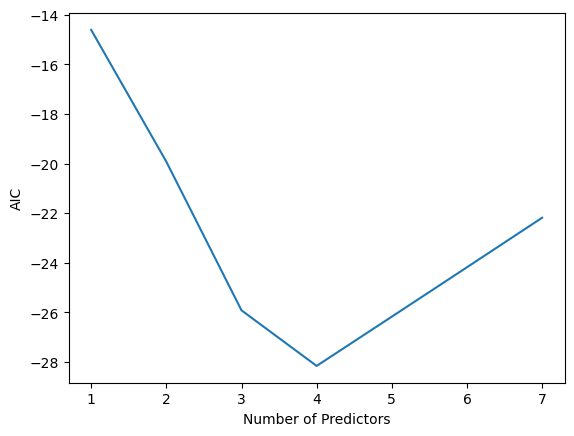

In [32]:
# Computing AIC and plotting
aic = 50 * np.log(rss/50) + np.arange(1,9)*2
plt.plot(np.arange(1,8), aic[1:])
plt.xlabel('Number of Predictors'); plt.ylabel('AIC'); 

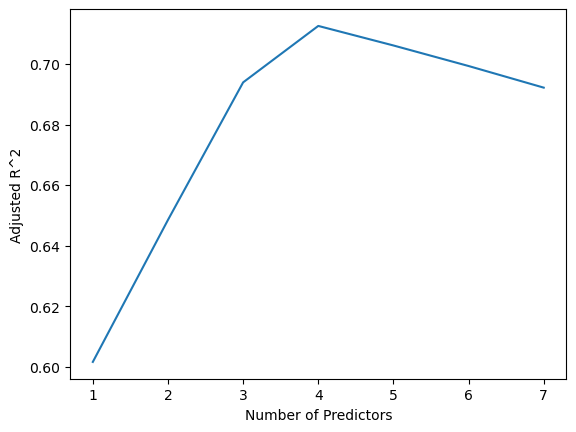

In [34]:
# Computing adjusted R² and plotting
adjr2 = 1 - (rss/(50 - np.arange(1,9)))/(rss[0]/49)
plt.plot(np.arange(1,8),adjr2[1:])
plt.xlabel('Number of Predictors'); plt.ylabel('Adjusted R^2');

- The model chosen from these methods is the same - we pick the four predictor model using Population, Murder, HSGrad, Frost.
- Computing the RSS for all subset models works well with few predictors. The number of subsets is $2^q$, where q is the number of predictors. As q increases, this becomes time-consuming. Efficient algorithms can help, but eventually, evaluating all subsets becomes impractical.
- A quicker method is to create a series of models, each with a different number of predictors. While we can’t explore every possible subset, we can still find a good option more efficiently. The scikit-learn package makes this easy. First, standardize the variables to have a zero mean and unit standard deviation:
    - Rescaling has the benefit of making the size of the regression coefficient reflect its importance in the model.

In [35]:
from sklearn.preprocessing import scale
scalstat = pd.DataFrame(scale(statedata), index=statedata.index, 
    columns=statedata.columns)
scalstat.head()

,Population,Income,Illiteracy,LifeExp,Murder,HSGrad,Frost,Area
State,,,,,,,,
AL,-0.142867,-1.334552,1.541248,-1.376023,2.113047,-1.476772,-1.641325,-0.237101
AK,-0.878225,3.089295,0.546895,-1.180373,1.073216,1.699888,0.923853,5.868329
AZ,-0.460315,0.154859,1.044071,-0.247272,0.115476,0.624326,-1.738491,0.505283
AR,-0.483394,-1.738961,1.209797,-0.164497,0.744848,-1.651863,-0.766833,-0.222457
CA,3.835528,1.114921,-0.116008,0.625629,0.799576,1.187120,-1.641325,1.013678


In [38]:
from sklearn import linear_model
# Step 1: Create a linear regression model instance
# 'fit_intercept=False' means we do not want the model to automatically include an intercept term
reg = linear_model.LinearRegression(fit_intercept=False)
# Step 2: Prepare the feature matrix X and the target variable y
# X contains all the columns except 'LifeExp'
X = scalstat.drop('LifeExp', axis=1)
# Step 3: Fit the linear regression model
# The model is trained using the feature matrix X and the target variable 'LifeExp'
reg.fit(X, scalstat.LifeExp)
# Step 5: Display the coefficients of the fitted model
# 'reg.coef_' contains the coefficients (weights) for each feature in X
print(reg.coef_)
print(reg.intercept_)

[ 0.17227607 -0.00998072  0.0153566  -0.82807917  0.29440196 -0.22207364
 -0.004693  ]
0.0


- The intercept is zero because we’ve standardized the data.
- The coefficient for Murder is the largest, showing it’s the most important, while Area is the smallest, indicating it’s the least important.
- Next, we use Recursive Feature Elimination (RFE), which removes the least important variable, refits the model, and repeats. This is similar to backward elimination, but while backward elimination selects the final model, RFE provides a sequence of potential models.

In [40]:
from sklearn.feature_selection import RFE
# Step 1: Create a linear regression model instance
# 'reg' is the linear regression model created in a previous step
# We will use this model in the RFE process
reg = linear_model.LinearRegression(fit_intercept=False)

# Step 2: Set up Recursive Feature Elimination (RFE)
# Initialize the RFE selector with the linear regression model and specify the number of features to select
# n_features_to_select=1 means we will rank all features and identify the most important one
selector = RFE(estimator=reg, n_features_to_select=1)

# Step 3: Fit the RFE selector to the data
# We pass the feature matrix X and target variable scalstat.LifeExp to fit the RFE model
selector = selector.fit(X, scalstat.LifeExp)

# Step 4: Display the feature ranking
# selector.ranking_ returns an array that represents the rank of each feature
# A rank of 1 means the feature is the most important, while higher ranks are less important
selector.ranking_

array([4, 6, 5, 1, 2, 3, 7])

In [54]:
list(scalstat.columns)

['Population',
 'Income',
 'Illiteracy',
 'LifeExp',
 'Murder',
 'HSGrad',
 'Frost',
 'Area']

In [41]:
# Show ranked predictors
X.columns[np.argsort(selector.ranking_)].tolist()

['Murder', 'HSGrad', 'Frost', 'Population', 'Illiteracy', 'Income', 'Area']

- Interestingly, this method produces the same sequence of candidate models as an exhaustive search, though this isn’t always the case.
- We can use AIC to select the best model, which will make the same choice here.
- With few predictors, an exhaustive search is preferable, but with more predictors, this method is more practical.
- Variable selection methods can be affected by outliers and influential points.
    - In this dataset, Alaska has very high leverage. If we exclude it and rerun the model selection, we get a different set of predictors.
- These methods are also sensitive to variable transformations. For example, the Area and Population variables are skewed, so applying a log transformation and redoing the model selection will yield different predictors.
- It’s best to start by fitting a model with all predictors, perform regression diagnostics, and address any unusual points or transformations before selecting the model.